In [1]:
%pip install tensorflow
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install scikit-learn
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data2 = pd.read_csv('depression_dataset_reddit_cleaned.csv')

In [9]:
processed_data = []
processed_labels = []

for i in range(len(train_data)):
    if train_data['label'][i] == 'nd' or train_data['label'][i] == 'do':
        processed_data.append(train_data['text'][i])
        processed_labels.append(train_data['label'][i])

In [10]:
# I need to split train data into labels and features
train_labels = np.array(processed_labels)
train_features = np.array(processed_data)

train_labels3 = train_data2['is_depression'].to_numpy()
train_features3 = train_data2['clean_text'].to_numpy()

In [11]:
test_labels = test_data['label'].to_numpy()
test_features = test_data['text'].to_numpy()

In [12]:
#remove stopwords from train_features
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
punctuation = set(['.', ',', '!', '?', ';', ':', '(', ')', '[', ']', '{', '}', '<', '>', '/', '\\', '|', '@', '#', '$', '%', '^', '&', '*', '-', '_', '+', '=', '~', '`', '"', "'"])

lemmatizer = WordNetLemmatizer()

for i in range(len(train_features)):
    word_tokens = train_features[i].split()
    filtered_sentence = [w for w in word_tokens if not w in stop_words and not w in punctuation]
    filtered_sentence = [lemmatizer.lemmatize(w) for w in filtered_sentence]
    train_features[i] = ' '.join(filtered_sentence)

# for i in range(len(train_features3)):
#     word_tokens = train_features3[i].split()
#     filtered_sentence = [w for w in word_tokens if not w in stop_words and not w in punctuation]
#     filtered_sentence = [lemmatizer.lemmatize(w) for w in filtered_sentence]
#     train_features3[i] = ' '.join(filtered_sentence)

for i in range(len(test_features)):
    word_tokens = test_features[i].split()
    filtered_sentence = [w for w in word_tokens if not w in stop_words and not w in punctuation]
    filtered_sentence = [lemmatizer.lemmatize(w) for w in filtered_sentence]
    test_features[i] = ' '.join(filtered_sentence)

#print(train_features)
#print(train_features3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
#get part of sppech for each word
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

train_features2 = []
test_features2 = []

# for i in range(len(train_features3)):
#     word_tokens = train_features3[i].split()
#     pos_tags = pos_tag(word_tokens)
#     pos_tags = [get_wordnet_pos(t) for _, t in pos_tags]
#     train_features2.append(pos_tags)

for i in range(len(train_features)):
    word_tokens = train_features[i].split()
    pos_tags = pos_tag(word_tokens)
    pos_tags = [get_wordnet_pos(t) for _, t in pos_tags]
    train_features2.append(pos_tags)

for i in range(len(test_features)):
    word_tokens = test_features[i].split()
    pos_tags = pos_tag(word_tokens)
    pos_tags = [get_wordnet_pos(t) for _, t in pos_tags]
    test_features2.append(pos_tags)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Andrei\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Andrei\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [6]:
# split train_features into train and validation
from sklearn.model_selection import train_test_split

train_features, val_features, train_labels, val_labels = train_test_split(train_features3, train_labels3, test_size=0.2, random_state=42)

In [14]:
# Tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
for i in range(len(train_features)):
    train_features[i] = train_features[i].lower()
for i in range(len(test_features)):
    test_features[i] = test_features[i].lower()
# for i in range(len(train_features3)):
#     train_features3[i] = train_features3[i].lower()

# tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

# for i in range(len(train_features)):
#     train_features[i] = train_features[i].lower()
# for i in range(len(val_features)):
#     val_features[i] = val_features[i].lower()

tokenizer.fit_on_texts(train_features)
#tokenizer.fit_on_texts(train_features3)
word_index = tokenizer.word_index
print(word_index)

# get sequences and pad them
# train_sequences = tokenizer.texts_to_sequences(train_features)
# train_padded = pad_sequences(train_sequences, padding='post').astype(np.float32)
# train_padded = train_padded[:, :100]

# val_sequences = tokenizer.texts_to_sequences(val_features)
# val_padded = pad_sequences(val_sequences, padding='post').astype(np.float32)
# val_padded = val_padded[:, :100]

# print(train_padded.shape, val_padded.shape)

train_sequences = tokenizer.texts_to_sequences(train_features)
train_padded = pad_sequences(train_sequences, padding='post').astype(np.float32)
train_padded = train_padded[:, :100]
for i in range(len(train_features2)):
    train_features2[i] = train_features2[i][:100] + [0] * (100 - len(train_features2[i]))
train_features2 = np.array(train_features2)

test_sequences = tokenizer.texts_to_sequences(test_features)
test_padded = pad_sequences(test_sequences, padding='post').astype(np.float32)
test_padded = test_padded[:, :100]
for i in range(len(test_features2)):
    test_features2[i] = test_features2[i][:100] + [0] * (100 - len(test_features2[i]))
test_features2 = np.array(test_features2)

{'<OOV>': 1, 'i': 2, "i'm": 3, 'like': 4, 'it': 5, 'time': 6, 'get': 7, 'know': 8, 'would': 9, 'feel': 10, 'really': 11, 'one': 12, 'want': 13, "i've": 14, 'me': 15, 'the': 16, 'year': 17, 'day': 18, 'thing': 19, 'much': 20, 'even': 21, 'also': 22, 'go': 23, 'make': 24, 'people': 25, 'this': 26, 'so': 27, 'going': 28, 'got': 29, 'my': 30, 'back': 31, 'good': 32, 'think': 33, 'work': 34, 'life': 35, 'way': 36, 'but': 37, 'something': 38, 'could': 39, 'first': 40, 'com': 41, 'anyone': 42, 'see': 43, 'still': 44, '2': 45, 'help': 46, 'since': 47, 'now': 48, 'never': 49, 'and': 50, '1': 51, 'friend': 52, 'https': 53, '3': 54, 'need': 55, "can't": 56, 'anything': 57, 'lot': 58, 'take': 59, 'new': 60, 'month': 61, 'last': 62, 'thought': 63, 'love': 64, 'school': 65, 'week': 66, 'he': 67, 'is': 68, 'if': 69, 'well': 70, 'started': 71, 'two': 72, 'game': 73, 'looking': 74, 'right': 75, 'say': 76, 'that': 77, 'in': 78, 'we': 79, 'always': 80, 'someone': 81, 'getting': 82, 'feeling': 83, 'you': 

In [9]:
print(test_features2.shape)

(800, 100)


In [15]:
from sklearn.preprocessing import LabelEncoder

#print distinct labels
print(np.unique(train_labels))
print(np.unique(test_labels))

pos_encoder = LabelEncoder()
pos_encoder.fit(train_features2.flatten())
for i in range(len(train_features2)):
    train_features2[i] = pos_encoder.transform(train_features2[i])
pos_encoder = LabelEncoder()
pos_encoder.fit(test_features2.flatten())
for i in range(len(test_features2)):
    test_features2[i] = pos_encoder.transform(test_features2[i])

train_features2 = train_features2.astype(np.int32)
test_features2 = test_features2.astype(np.int32)

# convert labels to distinct integers
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

['do' 'nd']
['do' 'nd']


In [12]:
train_padded = np.array(train_padded2)
print(train_padded2.shape)
#pad train_padded to have same shape as test_padded
test_padded = np.pad(test_padded, ((0,0), (0, 100 - test_padded.shape[1])), 'constant')
train_padded2 = np.pad(train_padded2, ((0,0), (0, 100 - train_padded2.shape[1])), 'constant')

print(test_padded.shape)
print(train_padded.shape)

(800, 100)
(800, 100)
(2800, 100)


In [12]:
print(test_features2.shape)

(800, 100)


In [1]:
# I will build a model that uses both the text and the part of speech tags
from tensorflow.keras import layers, Model

input1 = layers.Input(shape=(100,))
input2 = layers.Input(shape=(100,))
embedding = layers.Embedding(10000, 64)(input1)
lstm = layers.LSTM(128)(embedding)
concat = layers.Concatenate()([lstm, input2])
dense = layers.Dense(512, activation='relu')(concat)
dense = layers.Dense(128, activation='relu')(dense)
output = layers.Dense(1, activation='sigmoid')(dense)


model = Model(inputs=[input1, input2], outputs=output)

# compile the model with accuracy and f1 score

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.build(input_shape=(None, 100))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     98,816 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 228)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    117,248 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 921,857 (3.52 MB)

 Trainable params: 921,857 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
%pip install pydot
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


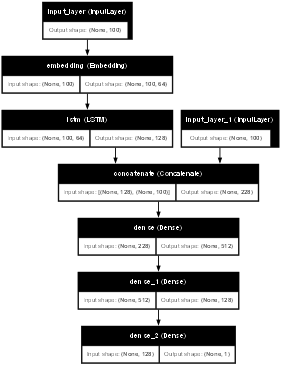

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True, dpi=32)

0.5525
0.5511422051706412
0.55
0.5416465076010287
0.54125
0.5256674340643807
0.50875
0.49945790526954287


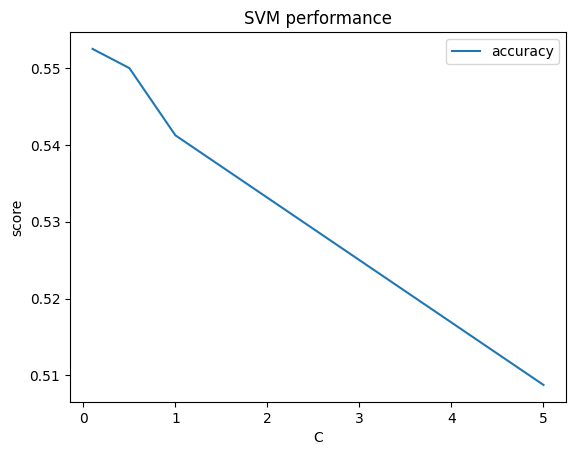

In [28]:
# train a svm model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

results_acc = []
results_f1 = []

for C in [.1, .5, 1, 5]:
    svm = SVC(kernel='rbf', C=C, gamma='scale')
    svm.fit(train_padded, train_labels)
    svm_predictions = svm.predict(test_padded)
    print(accuracy_score(test_labels, svm_predictions))
    print(f1_score(test_labels, svm_predictions, average='macro'))
    results_acc.append((accuracy_score(test_labels, svm_predictions)))
    results_f1.append((f1_score(test_labels, svm_predictions, average='macro')))

# plot the results
# add axis labels and a title
plt.xlabel('C')
plt.ylabel('score')
plt.title('SVM performance')
plt.plot([.1, .5, 1, 5], results_acc, label='accuracy')
plt.plot([.1, .5, 1, 5], results_f1, label='f1 score')
plt.legend()



In [16]:
print(train_padded.shape, train_features2.shape, train_labels.shape)
print(test_padded.shape, test_features2.shape, test_labels.shape)

(800, 100) (800, 100) (800,)
(800, 100) (800, 100) (800,)


In [27]:
# Train the model
# train_labels = train_labels.astype(np.float64)
# test_labels = test_labels.astype(np.float64)

model.fit([train_padded, train_features2], train_labels, validation_data=([test_padded, test_features2], test_labels), epochs=350)


Epoch 1/350
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5437 - loss: 0.7391 - val_accuracy: 0.5238 - val_loss: 0.7116
Epoch 2/350
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6335 - loss: 0.6439 - val_accuracy: 0.5150 - val_loss: 0.7880
Epoch 3/350
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6627 - loss: 0.6173 - val_accuracy: 0.5437 - val_loss: 1.1441
Epoch 4/350
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7610 - loss: 0.4610 - val_accuracy: 0.5312 - val_loss: 1.5174
Epoch 5/350
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7971 - loss: 0.4209 - val_accuracy: 0.5337 - val_loss: 2.3764
Epoch 6/350
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8566 - loss: 0.3175 - val_accuracy: 0.5113 - val_loss: 0.9772
Epoch 7/350
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7980 - loss: 0.4359 - val_accuracy: 0.5075 - val_loss: 0.8666
Epoch 8/350
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8457 - loss: 0.3644 - val_accuracy: 0.